## Analysis of Glasgow Traffic Accidents and Their Severity

Programming Tools for Urban Analytics, Univeristy of Glasgow  
26/03/2023

## 1. Introduction

Traffic accidents result in significant economic costs and casualties (AlMamlook et al, 2019). In 2019, $46 billion of economic costs were spent on traffic accidents in the US, representing 14% of all economic costs, and 10,192 people died in traffic accidents (NHTSA, 2023). While traffic accidents of varying severity can affect economic costs to varying degrees. In 2020, a fatal crash in the UK cost 2,120,669 pounds per crash, approximately 85 times more than a slight crash (Statista, 2021). Therefore, researchers should pay attention to the analysis of the severity of traffic accidents.

Road construction never stopped in Glasgow after COVID-19, which tends to increase the probability of traffic accidents (Mou et al, 2022). In addition, Abellán et al. (2013) showed predictions of traffic accident severity can help road safety-related managers to make decisions. Thus, in order to reduce the severity of traffic accidents, and to better allocate financial and human resources and optimise road safety policies, this project seeks to explore the following elements of traffic accidents in Glasgow:  

1) The temporal and spatial distribution of traffic accidents and the conditions that influence their occurrence.  
2) The distribution and prediction of the severity of traffic accidents.

This project can have a positive impact on individuals and society by reducing the risk of traffic accidents, especially serious and fatal accidents. Specifically, the exploration of the distribution of traffic accidents can provide the traveller with a quick overview and travel options before travelling. The prediction of traffic accident severity can provide direction and a basis for road safety managers and policy-makers.

The dataset used for the analysis is taken from the UK Government Road Safety Data (https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data), which contains traffic accidents in all UK cities and their occurrence time, geographical information and conditions (e.g.: weather, light, etc.). 

In this data, the data on the conditions in which accidents occur are presented as class data, which are collected from STATS19 road accident injury statistics report form (https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/995422/stats19.pdf), which contain decoding of the class data. A total of 6 years of data from 2016 to 2021 are selected for this project to analyze, with a total of 699,060 data items.


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime
import calplot

import folium
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN as dbscan
import math

from imblearn.over_sampling import SMOTE

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

C:\Users\dell\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
accident2021 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2021.csv', low_memory=False)
accident2020 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2020.csv', low_memory=False)
accident2019 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2019.csv', low_memory=False)
accident2018 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2018.csv', low_memory=False)
accident2017 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2017.csv', low_memory=False)
accident2016 = pd.read_csv('https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-2016.csv', low_memory=False)

In [3]:
accident_all = pd.concat([accident2021, accident2020, accident2019, accident2018, accident2017, accident2016], join='inner')
accident_all.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2021010287148           2021          010287148               521508.0   
1  2021010287149           2021          010287149               535379.0   
2  2021010287151           2021          010287151               529701.0   
3  2021010287155           2021          010287155               525312.0   
4  2021010287157           2021          010287157               512144.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                193079.0  -0.246102  51.623425             1   
1                180783.0  -0.050574  51.509767             1   
2                170398.0  -0.136152  51.417769             1   
3                178385.0  -0.196411  51.490536             1   
4                171526.0  -0.388169  51.431649             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   3  ...   
1                  2                   2  ...   
2                  2                   2  ...   
3                  1                   1  ...   
4                  3                   4  ...   

   pedestrian_crossing_physical_facilities light_conditions  \
0                                        0                4   
1                                        5                4   
2                                        5                4   
3                                        4                4   
4                                        0                4   

   weather_conditions road_surface_conditions  special_conditions_at_site  \
0                   7                       4                           1   
1                   1                       1                           0   
2                   1                       1                           0   
3                   1                       1                           0   
4                   1                       1                           0   

  carriageway_hazards urban_or_rural_area  \
0                   0                   1   
1                   0                   1   
2                   0                   1   
3                   0                   1   
4                   0                   1   

   did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                            1                2   
1                                            1                2   
2                                            1                2   
3                                            1                2   
4                                            1                2   

   lsoa_of_accident_location  
0                  E01000263  
1                  E01004303  
2                  E01003146  
3                  E01002847  
4                  E01002608  

[5 rows x 36 columns]

In [4]:
accident_all.shape

(699060, 36)

## 2. Data Cleaning
Data on traffic accidents in Glasgow is selected with 5,218 items which are 0.75% of the UK data by latitude, longitude for each incident and Glasgow boundary shapefile data (Glasgow boundary shapefile data source: https://data.glasgow.gov.uk/datasets/GlasgowGIS::low-emission-zone-lez/explore). And the dataset is examined to see that there are no duplicated or missing data. And then the format of the date and time data is changed. Due to the precise timing of the accident to the minute, the time is changed to its nearest hour (24-hour system) to facilitate statistics and analysis.

In [5]:
map1 = gpd.read_file('GlasgowBdry_2011\GlasgowBdry_2011.shp')
accident_point = gpd.GeoDataFrame(accident_all, geometry=gpd.points_from_xy(accident_all.longitude, accident_all.latitude),crs=4326)
accident_point = accident_point.to_crs(27700)
accident = gpd.sjoin(accident_point, map1, predicate = 'within')
accident.shape

(5218, 58)

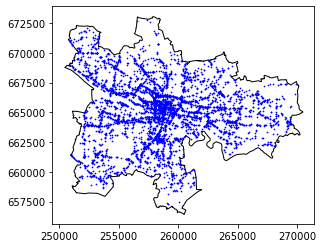

In [6]:
base = map1.plot(color='white', edgecolor='black')
accident_map = accident.plot(ax=base, marker='o', color='blue', markersize=0.5)

In [7]:
#delete redundant columns
accident = accident.drop(['geometry', 'index_right', 'NAME', 'AREA_CODE', 'DESCRIPTIO', 'FILE_NAME', 'NUMBER', 'NUMBER0', 'POLYGON_ID', 'UNIT_ID', 'CODE', 'HECTARES', 'AREA', 'TYPE_CODE', 'DESCRIPT0', 'TYPE_COD0', 'DESCRIPT1', 'Council', 'FILE_NAM_1', 'Pop', 'Density', 'response'], axis=1)

In [8]:
accident_duplicated = accident[accident.accident_index.duplicated()]
len(accident_duplicated)

0

In [9]:
accident.isnull().values.any()

False

In [10]:
accident['date'] = pd.to_datetime(accident['date'], format = '%d/%m/%Y' )
accident['month'] = accident['date'].dt.month
accident['time'] = pd.to_datetime(accident['time'], format = '%H:%M').dt.hour
accident.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
97186  2021991011286           2021          991011286               262511.0   
97189  2021991011388           2021          991011388               257583.0   
97201  2021991011727           2021          991011727               266075.0   
97203  2021991011732           2021          991011732               263576.0   
97222  2021991012922           2021          991012922               261044.0   

       location_northing_osgr  longitude   latitude  police_force  \
97186                666029.0  -4.198684  55.867756            99   
97189                660249.0  -4.274333  55.814433            99   
97201                665221.0  -4.141377  55.861505            99   
97203                663390.0  -4.180351  55.844365            99   
97222                665510.0  -4.221841  55.862675            99   

       accident_severity  number_of_vehicles  ...  light_conditions  \
97186                  3                   1  ...                 1   
97189                  3                   3  ...                 4   
97201                  2                   1  ...                 1   
97203                  3                   2  ...                 1   
97222                  3                   1  ...                 4   

      weather_conditions  road_surface_conditions  special_conditions_at_site  \
97186                  1                        2                           0   
97189                  8                        4                           0   
97201                  1                        2                           0   
97203                  8                        4                           0   
97222                  8                        4                           0   

       carriageway_hazards urban_or_rural_area  \
97186                    7                   1   
97189                    0                   1   
97201                    0                   1   
97203                    0                   1   
97222                    0                   1   

      did_police_officer_attend_scene_of_accident  trunk_road_flag  \
97186                                           1               -1   
97189                                           2               -1   
97201                                           1               -1   
97203                                           1               -1   
97222                                           2               -1   

       lsoa_of_accident_location  month  
97186                         -1      1  
97189                         -1      1  
97201                         -1      1  
97203                         -1      1  
97222                         -1      1  

[5 rows x 37 columns]

In [11]:
accident.describe()

accident_year  location_easting_osgr  location_northing_osgr  \
count    5218.000000            5218.000000             5218.000000   
mean     2018.004216          258570.498467           665092.714450   
std         1.652358            3885.964738             2492.205406   
min      2016.000000          250830.000000           657265.000000   
25%      2017.000000          255937.500000           663828.500000   
50%      2018.000000          258379.000000           665234.500000   
75%      2019.000000          260589.250000           666589.000000   
max      2021.000000          269892.000000           672791.000000   

         longitude     latitude  police_force  accident_severity  \
count  5218.000000  5218.000000   5218.000000        5218.000000   
mean     -4.261125    55.858206     97.429283           2.789383   
std       0.062128     0.022330      0.821226           0.432425   
min      -4.387937    55.788141     97.000000           1.000000   
25%      -4.302836    55.846246     97.000000           3.000000   
50%      -4.264064    55.859774     97.000000           3.000000   
75%      -4.228970    55.871685     97.000000           3.000000   
max      -4.081454    55.926967     99.000000           3.000000   

       number_of_vehicles  number_of_casualties  day_of_week  ...  \
count         5218.000000            5218.00000  5218.000000  ...   
mean             1.815638               1.24703     4.137217  ...   
std              0.741787               0.72690     1.921786  ...   
min              1.000000               1.00000     1.000000  ...   
25%              1.000000               1.00000     3.000000  ...   
50%              2.000000               1.00000     4.000000  ...   
75%              2.000000               1.00000     6.000000  ...   
max             13.000000              29.00000     7.000000  ...   

       pedestrian_crossing_physical_facilities  light_conditions  \
count                              5218.000000       5218.000000   
mean                                  1.433116          1.991376   
std                                   2.183334          1.497721   
min                                   0.000000          1.000000   
25%                                   0.000000          1.000000   
50%                                   0.000000          1.000000   
75%                                   4.000000          4.000000   
max                                   8.000000          7.000000   

       weather_conditions  road_surface_conditions  \
count         5218.000000              5218.000000   
mean             1.641625                 1.404561   
std              1.680307                 0.580986   
min              1.000000                 1.000000   
25%              1.000000                 1.000000   
50%              1.000000                 1.000000   
75%              2.000000                 2.000000   
max              9.000000                 5.000000   

       special_conditions_at_site  carriageway_hazards  urban_or_rural_area  \
count                 5218.000000          5218.000000          5218.000000   
mean                     0.098122             0.057493             1.025489   
std                      0.620980             0.513336             0.157619   
min                      0.000000             0.000000             1.000000   
25%                      0.000000             0.000000             1.000000   
50%                      0.000000             0.000000             1.000000   
75%                      0.000000             0.000000             1.000000   
max                      7.000000             7.000000             2.000000   

       did_police_officer_attend_scene_of_accident  trunk_road_flag  \
count                                  5218.000000           5218.0   
mean                                      1.253545             -1.0   
std                                       0.440337              0.0   
min                                 

In [12]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5218 entries, 97186 to 135736
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   accident_index                               5218 non-null   object        
 1   accident_year                                5218 non-null   int64         
 2   accident_reference                           5218 non-null   object        
 3   location_easting_osgr                        5218 non-null   float64       
 4   location_northing_osgr                       5218 non-null   float64       
 5   longitude                                    5218 non-null   float64       
 6   latitude                                     5218 non-null   float64       
 7   police_force                                 5218 non-null   int64         
 8   accident_severity                            5218 non-null   int64      

## 3. Exploratory Analysis

## Date and time
The number of traffic accidents varies with time and date. The bar charts below show the change in the number of traffic accidents by years, months and the day of week. 

There has been a significantly decreased trend in the number of traffic accidents in Glasgow in recent years, suggesting that management of road safety has been effective, particularly in 2020 when there was a reduction of almost a third, but only a slight reduction in 2021. This may be due to the outbreak of COVID-19 in 2020 reducing travel by the public and thus traffic accidents by a significant amount, with a similar pattern in 2021 as in 2020.

There is an average of 435 traffic accidents per month in Glasgow. October has the highest number of accidents, about 12% above the average, followed by January and November, while April, June and July have relatively few accidents. This may be related to the amount of rainfall and hours of sunshine. Similarly, Glasgow has an average of 745 traffic accidents per weekday, with the most occurring on Saturdays, as opposed to Mondays.

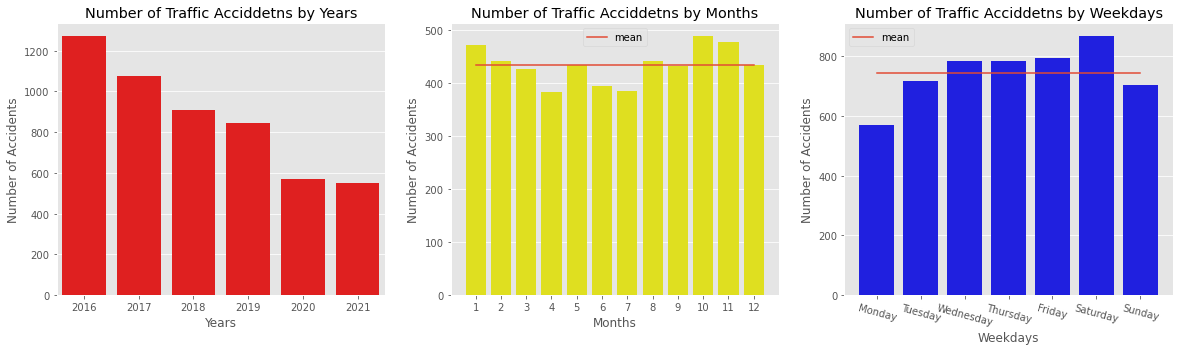

In [13]:
year = accident["accident_year"].value_counts().sort_index()
years = year.keys()
num_years = year.values

month = accident['month'].value_counts().sort_index()
months = month.keys()
num_months = month.values
mean_m = num_months.mean()

week = accident["day_of_week"].value_counts().sort_index()
weeks = week.keys()
num_weeks = week.values
mean_w = num_weeks.mean()
labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize = (20,5),facecolor='White')
plt.style.use('ggplot')

plt.subplot(1, 3, 1)
sns.barplot(x = years, y = num_years, color="red")
plt.ylabel("Number of Accidents")
plt.xlabel("Years")
plt.title("Number of Traffic Acciddetns by Years")

plt.subplot(1, 3, 2)
sns.barplot(x = months, y = num_months, color="yellow")
plt.ylabel("Number of Accidents")
plt.xlabel("Months")
plt.title("Number of Traffic Acciddetns by Months")
sns.lineplot(x=[0,1,2,3,4,5,6,7,8,9,10,11],y=mean_m,label='mean')

plt.subplot(1, 3, 3)
#sns.barplot(x = weeks, y = num_weeks, color="blue")
sns.barplot(x = labels, y = num_weeks, color="blue")
plt.title("Number of Traffic Acciddetns by Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Accidents")
sns.lineplot(x=[0,1,2,3,4,5,6],y=mean_w,label='mean')
plt.xticks(rotation = -15)

plt.show()

The graph below is a hotspot map of the number of traffic accidents per day in Glasgow from 2016 to 2021, which also shows the fact that traffic accidents are decreasing year on year. It is worth mentioning that the highest number of traffic accidents occurred on 5 February 2016.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x734.4 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E14963DF0>,
       dtype=object))

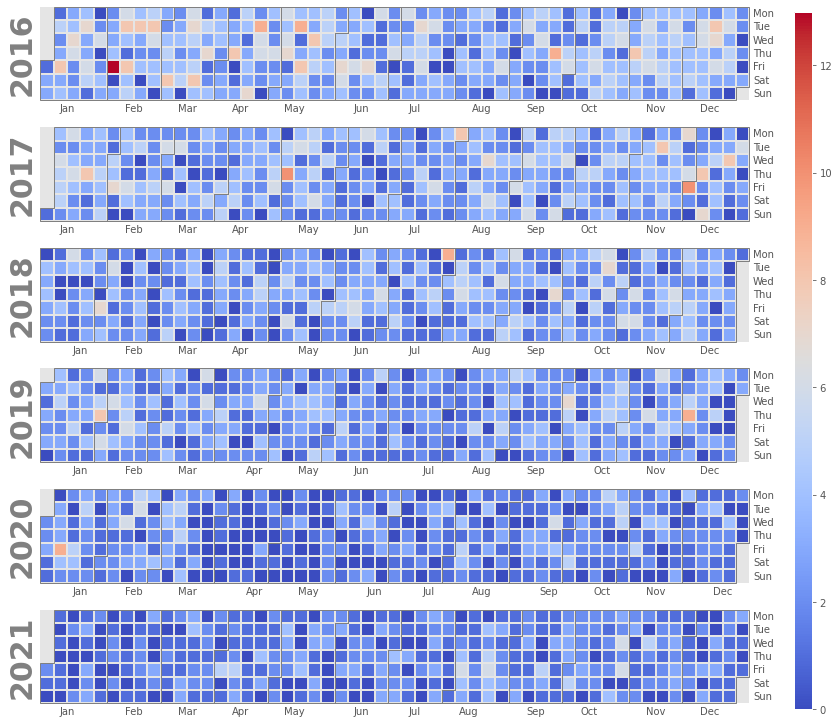

In [14]:
#Heatmaps
date = accident.date.value_counts().rename_axis('Date').to_frame('Number of Accidents').sort_index()
calplot.calplot(date['Number of Accidents'], cmap="coolwarm", colorbar=True, linewidth = 1)

The morning and evening peaks have the highest number of travellers and vehicles, so they are most likely to be involved in traffic accidents. The chart below shows the hotspots for the number of traffic accidents per hour of the day. The time period between 3 pm and 7 pm is the most likely to see the highest number of accidents, especially at 5 pm, and there are also relatively frequent accidents at 8 am.

<function matplotlib.pyplot.show(*args, **kw)>

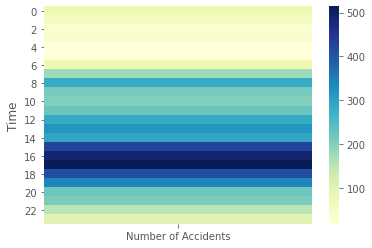

In [15]:
time = accident.time.value_counts().rename_axis('Time').to_frame('Number of Accidents').sort_index()

ax = sns.heatmap(time,cmap="YlGnBu") 
plt.yticks(rotation =0)
plt.show

## Severity
According to Transport Scotland's definition (2014), there are three categories of traffic accident severity, which are slight, serious and fatal:

• **Slight accident**: At least one person suffers a slight injury and no one suffers a serious or fatal injury.  
• **Serious accident**: At least one person suffers a serious injury and no one suffers a fatal injury.  
• **Fatal accident**: At least one person suffers a fatal injury, i.e., the person dies less than 30 days after the accident.

The graph below shows a pie chart of the distribution of the severity of traffic accidents and a line graph of their change from 2016 to 2021. Slight accidents account for 80% of traffic accidents in Glasgow, compared to 1% of fatal accidents. The number of fatal and serious accidents does not change much in this period, while the number of serious accidents fluctuates slightly in 2019. In contrast, the number of slight accidents decreases significantly each year, indicating that the decrease in the total number of traffic accidents is due to a decrease in the number of slight accidents. However, it is worth mentioning that although the number of fatal accidents is small, each one has a nasty impact and a huge financial loss.

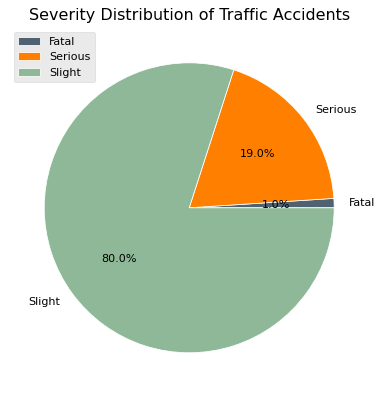

In [16]:
severity = accident["accident_severity"].value_counts().sort_index()

key_severity = severity.keys()
num_severity = severity.values
labels = ['Fatal','Serious','Slight']

figure(figsize=(6, 6), dpi=80)
colors = ['#4F6272', '#ff7f00', '#8EB897']
plt.pie(num_severity, labels = labels, colors=colors, wedgeprops = { 'linewidth' : 0.7, 'edgecolor' : 'white' }, autopct='%.1f%%')
plt.legend()
plt.title("Severity Distribution of Traffic Accidents")
plt.show()

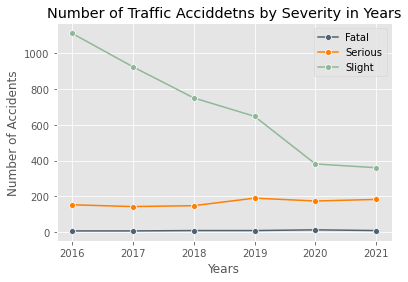

In [17]:
s1 = accident.loc[accident['accident_severity'] == 1]
s1_year = s1["accident_year"].value_counts().sort_index()
s2 = accident.loc[accident['accident_severity'] == 2]
s2_year = s2["accident_year"].value_counts().sort_index()
s3 = accident.loc[accident['accident_severity'] == 3]
s3_year = s3["accident_year"].value_counts().sort_index()

sns.lineplot(s1_year.keys(), s1_year.values, marker='o', color="#4F6272")
sns.lineplot(s1_year.keys(), s2_year.values, marker='o', color="#ff7f00")
sns.lineplot(s1_year.keys(), s3_year.values, marker='o', color="#8EB897")

plt.legend(['Fatal','Serious','Slight'])
plt.ylabel("Number of Accidents")
plt.xlabel("Years")
plt.title("Number of Traffic Acciddetns by Severity in Years")

plt.show()

## Other conditions
There are many factors that influence traffic accidents, and the bar charts below show the number of accidents that occur under weather conditions, road type, light conditions, speed limits, junction detail and road surface conditions respectively. 

In [18]:
#Road type
road_type = accident["road_type"].value_counts().sort_index()
key_road_type = road_type.keys()
num_road_type = road_type.values
#Weather
weather_conditions = accident["weather_conditions"].value_counts().sort_index()
weather = weather_conditions.keys()
num_weather = weather_conditions.values
#Light
light_conditions = accident["light_conditions"].value_counts().sort_index()
light = light_conditions.keys()
num_light = light_conditions.values
#Speed limit
speed_limit = accident["speed_limit"].value_counts().sort_index()
speed_limit = accident["speed_limit"].value_counts().sort_index()
key_speed = speed_limit.keys()
num_speed = speed_limit.values
#Junction detail
junction_detail = accident["junction_detail"].value_counts().sort_index()
junction_detail = accident["junction_detail"].value_counts().sort_index()
key_junction_detail = junction_detail.keys()
num_junction_detail = junction_detail.values
#Road surface conditions
road_surface_conditions = accident["road_surface_conditions"].value_counts().sort_index()
key_road_surface_conditions = road_surface_conditions.keys()
num_road_surface_conditions = road_surface_conditions.values

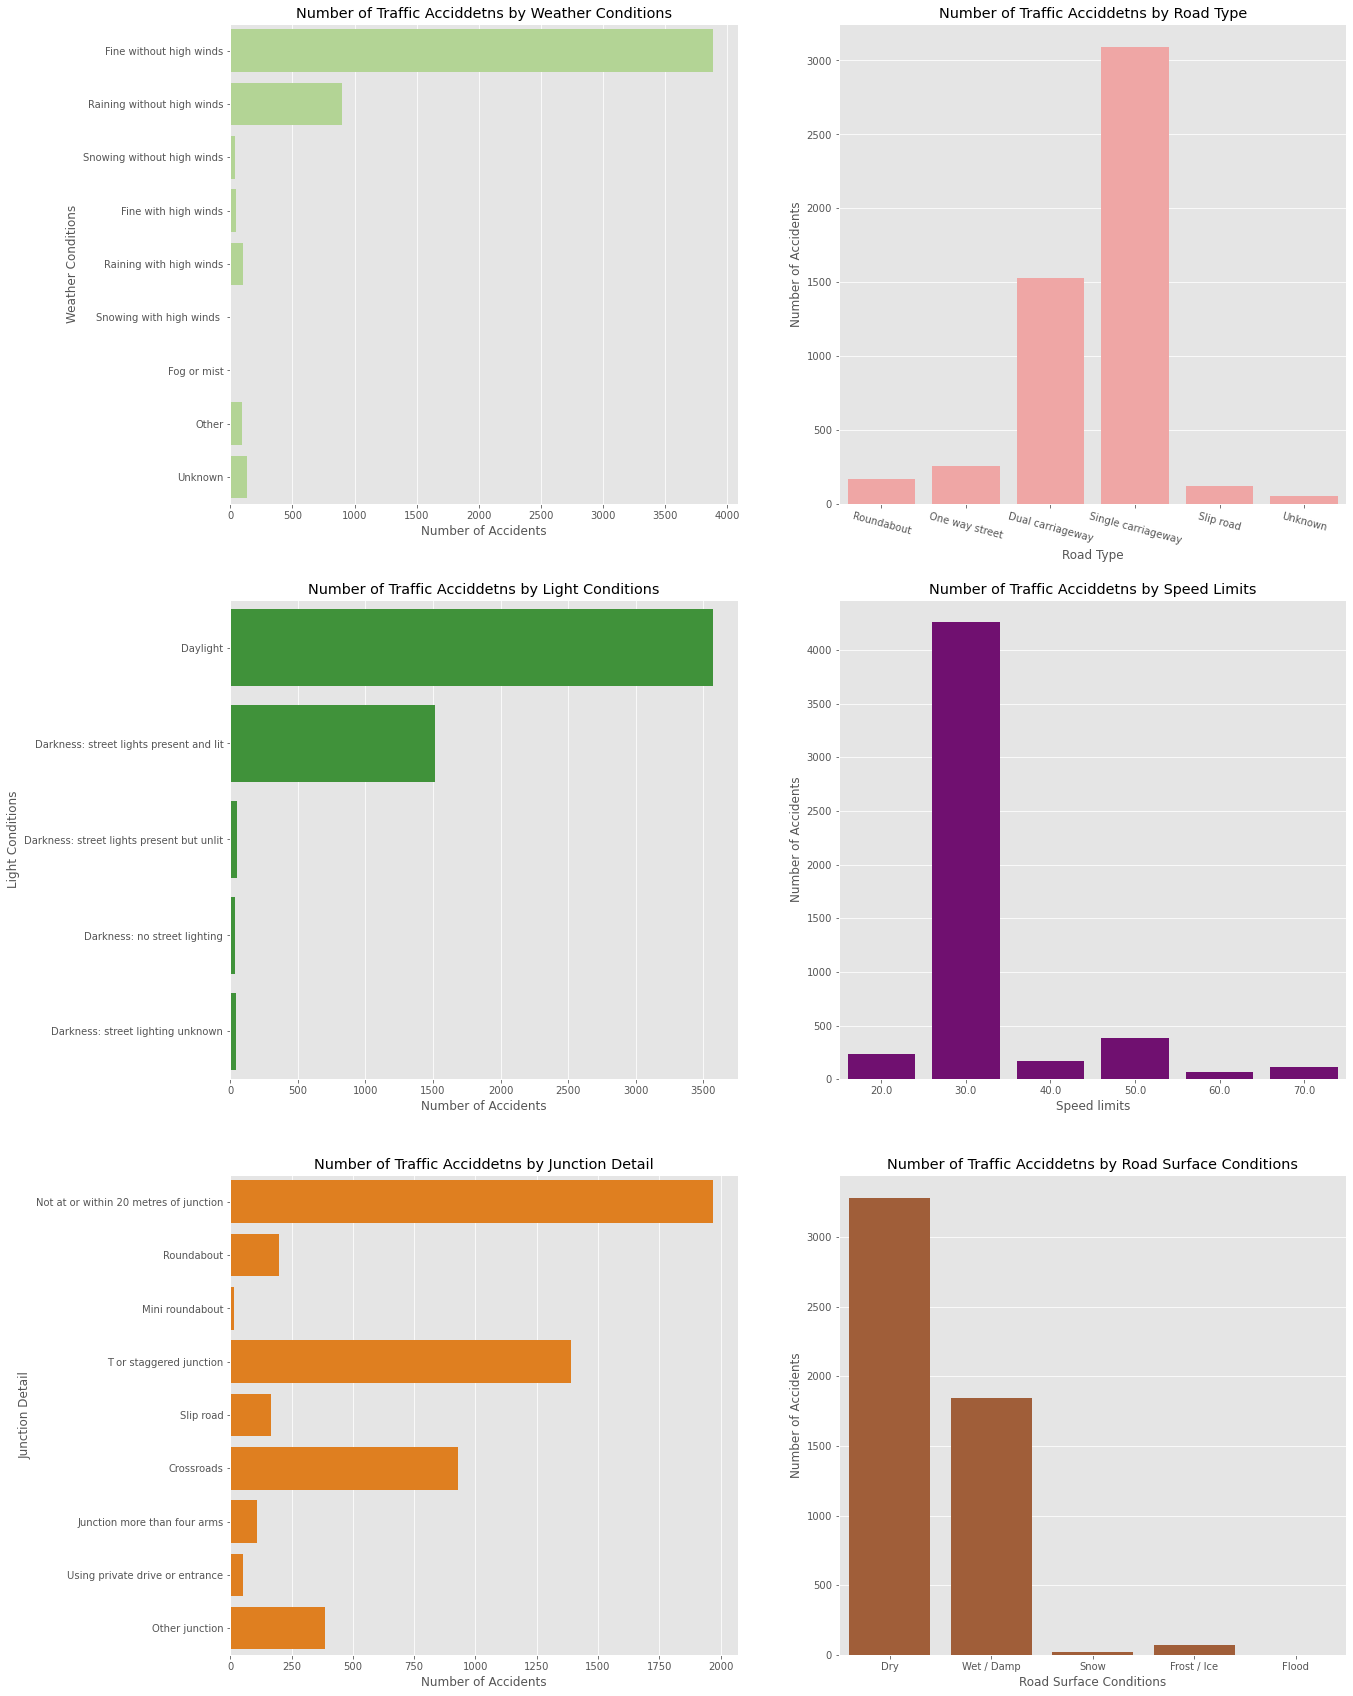

In [19]:
plt.figure(figsize = (20,30),facecolor='White')
plt.style.use('ggplot')

plt.subplot(3, 2, 1)
labels = ['Fine without high winds','Raining without high winds','Snowing without high winds','Fine with high winds','Raining with high winds','Snowing with high winds ','Fog or mist','Other','Unknown']
sns.barplot(y = labels, x = num_weather, color="#b2df8a")
plt.xlabel("Number of Accidents")
plt.ylabel("Weather Conditions")
plt.title("Number of Traffic Acciddetns by Weather Conditions")

plt.subplot(3, 2, 2)
labels = ['Roundabout','One way street','Dual carriageway','Single carriageway','Slip road','Unknown']
sns.barplot(x = labels, y = num_road_type, color="#fb9a99")
plt.ylabel("Number of Accidents")
plt.xlabel("Road Type")
plt.title("Number of Traffic Acciddetns by Road Type")
plt.xticks(rotation = -15)

plt.subplot(3, 2, 3)
labels = ['Daylight','Darkness: street lights present and lit','Darkness: street lights present but unlit','Darkness: no street lighting','Darkness: street lighting unknown']
sns.barplot(y = labels, x = num_light, color="#33a02c")
plt.xlabel("Number of Accidents")
plt.ylabel("Light Conditions")
plt.title("Number of Traffic Acciddetns by Light Conditions")

plt.subplot(3, 2, 4)
sns.barplot(x = key_speed, y = num_speed, color="purple")
plt.ylabel("Number of Accidents")
plt.xlabel("Speed limits")
plt.title("Number of Traffic Acciddetns by Speed Limits")

plt.subplot(3, 2, 5)
labels = ['Not at or within 20 metres of junction','Roundabout','Mini roundabout','T or staggered junction','Slip road','Crossroads','Junction more than four arms','Using private drive or entrance','Other junction']
sns.barplot(y = labels, x = num_junction_detail, color="#ff7f00")
plt.xlabel("Number of Accidents")
plt.ylabel("Junction Detail")
plt.title("Number of Traffic Acciddetns by Junction Detail")

plt.subplot(3, 2, 6)
labels = ['Dry','Wet / Damp','Snow','Frost / Ice','Flood']
sns.barplot(x = labels, y = num_road_surface_conditions, color="#b15928")
plt.ylabel("Number of Accidents")
plt.xlabel("Road Surface Conditions")
plt.title("Number of Traffic Acciddetns by Road Surface Conditions")

plt.show()

The following is a detailed explanation of the number of traffic accidents under these 6 conditions:

**Weather conditions**: In fact, 75% of accidents occur in fine weather without high winds, more than four times as many as in rainy weather without high winds, which is the second most frequent category. And in weather with high winds, accidents are more likely to occur in rainy weather than in good weather. While fewer accidents occur in other weather conditions (snowy and fog or mist), and the infrequency of these weather conditions may be one of the reasons.

**Road type**: The single carriageway is the most accident-prone road type compared to the roundabout, one-way street and slip road, with 60% of accidents occurring on this road type, which is above twice as many as on the dual carriageway.

**Light conditions**: There are 68% of traffic accidents in daylight conditions. And in dark conditions, accidents on street lights present and lit roads accounted for the dominant part, 29% of the total, compared to street lights present but unlit and no street lighting.

**Speed limits**: Eighty-two per cent of accidents occur on roads with a speed limit of 30, which means traffic accidents almost always occur on this speed-limited road, while 60 is the least frequent, at only 1.2 per cent. Although other speed limits account for a relatively small number of accidents, the number of accidents at the 50-speed limit is the second highest, about twice as many as at the 20-speed limit.

**Junction detail**: More traffic accidents occur near junctions and at crossroads. Specifically, the highest number of traffic accidents occurred not at or within 20 metres of the junction with 38%, followed by T or staggered junctions with 27%, which is 1.5 times more than at crossroads. Whereas, the least number of accidents occurred at mini-roundabouts and relatively few at junctions with more than four arms and using private drive or entrance.

**Road surface conditions**: There are 98% of traffic accidents on dry and wet road surfaces, with the number of accidents on dry road surfaces being approximately twice as high as on wet roads. In contrast, very few accidents occurred on other road surface conditions (snow, frost and flood), with only two of them occurring on flooded roads (surface water over 3cm deep) during these six years.


## 4. Geographical Data Analysis
The map below shows the geographical locations where traffic accidents occur based on longitude and latitude. We can roughly see the high number of traffic accidents that occur in the city centre and on several major roads.

In [20]:
def greatcircle(x,y):
    lat1, long1 = x[0], x[1]
    lat2, long2 = y[0], y[1]
    dist = great_circle((lat1,long1),(lat2,long2)).meters
    return dist

In [21]:
eps = 100 #distance in meters
min_samples = 10

accident_dbc = accident

loc = accident_dbc[['latitude','longitude']]
dbc = dbscan(eps = eps, min_samples = min_samples, metric=greatcircle).fit(loc)

labels = dbc.labels_
unique_labels = np.unique(dbc.labels_)

#print(unique_labels)

accident_dbc['Cluster'] = labels

In [22]:
location = accident_dbc['latitude'].mean(), accident_dbc['longitude'].mean()
m1 = folium.Map(location=location,zoom_start=11, max_bounds=True)
folium.TileLayer('cartodbpositron').add_to(m1)
for i in range(0,len(accident)):
    #folium.CircleMarker([accident['latitude'].iloc[i],accident['longitude'].iloc[i]], radius = 1, color = 'red', fill = col).add_to(m1)
    folium.CircleMarker([accident['latitude'].iloc[i],accident['longitude'].iloc[i]], radius = 1, color = 'red').add_to(m1)
m1

To explore the spatial distribution of traffic accidents and hotspots in Glasgow, this section uses density-based clustering to identify areas of high traffic accident density. Points clustered together are grouped together and each group is labelled with a different colour and displayed on the map below. From this map, the following information can be obtained:

1. The city centre is the area of Glasgow with the highest density of traffic accidents.
2. Traffic accidents have occurred almost everywhere in the section of the M8 motorway close to the city centre.
3. Road junctions and busy areas are areas with a high incidence of traffic accidents.
4. The roundabout at the junction of the M8 motorway and M73 motorway in the east of Glasgow is accident-prone, even though it is far from the city centre.

The M8 is the motorway linking Glasgow to Edinburgh, which is the busiest motorway in Scotland (Department for Transport, 2022). And the M73 is the motorway linking Glasgow to North Lanarkshire.


In [23]:
m2 = folium.Map(location=location,zoom_start=13, max_bounds=True)

folium.TileLayer('cartodbpositron').add_to(m2)

clust_colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

for i in range(0,len(accident_dbc)):
    colouridx = accident_dbc['Cluster'].iloc[i]
    if colouridx == -1:
        pass
    else:
        col = clust_colours[colouridx%len(clust_colours)]
        folium.CircleMarker([accident_dbc['latitude'].iloc[i],accident_dbc['longitude'].iloc[i]], radius = 1, color = col, fill = col).add_to(m2)

m2

The map below shows the geographical distribution of the three levels of severity of traffic accidents, with blue dots representing slight accidents, orange dots representing serious accidents and purple dots representing fatal accidents. We can know the areas where serious and fatal accidents occur are more dispersed.

In [24]:
m3 = folium.Map(location=location,zoom_start=11, max_bounds=True)

folium.TileLayer('cartodbpositron').add_to(m3)

clust_colours = ['#a6cee3','#1f78b4','#b2df8a']

for i in range(0,len(accident)):
    if accident['accident_severity'].iloc[i] == 3:
        folium.CircleMarker([accident['latitude'].iloc[i],accident['longitude'].iloc[i]], radius = 1, color = '#a6cee3', fill = col).add_to(m3)
    if accident['accident_severity'].iloc[i] == 2:
        folium.CircleMarker([accident['latitude'].iloc[i],accident['longitude'].iloc[i]], radius = 1, color = 'orange', fill = col).add_to(m3)
    if accident['accident_severity'].iloc[i] == 1:
        folium.CircleMarker([accident['latitude'].iloc[i],accident['longitude'].iloc[i]], radius = 1, color = 'purple', fill = col).add_to(m3)
m3

## 5. Feature Engineering 
## Correlation matrix
As this dataset has many features, in order to predict the severity of traffic accidents, the features are screened as predictions by testing the correlation between features (as shown in the matrix below).

As can be seen from the matrix below, there is a high correlation between the junction information and road class, speed limits and urban or rural areas and so on. Therefore, based on the correlation and the real significance of the features, these features are selected for the project to predict accident severity: longitude, latitude, accident year, month, time, day of the week, road type, speed limit, junction detail, light conditions, weather conditions and road surface conditions.

<ipython-input-25-86d228e849d8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = accident.corr()


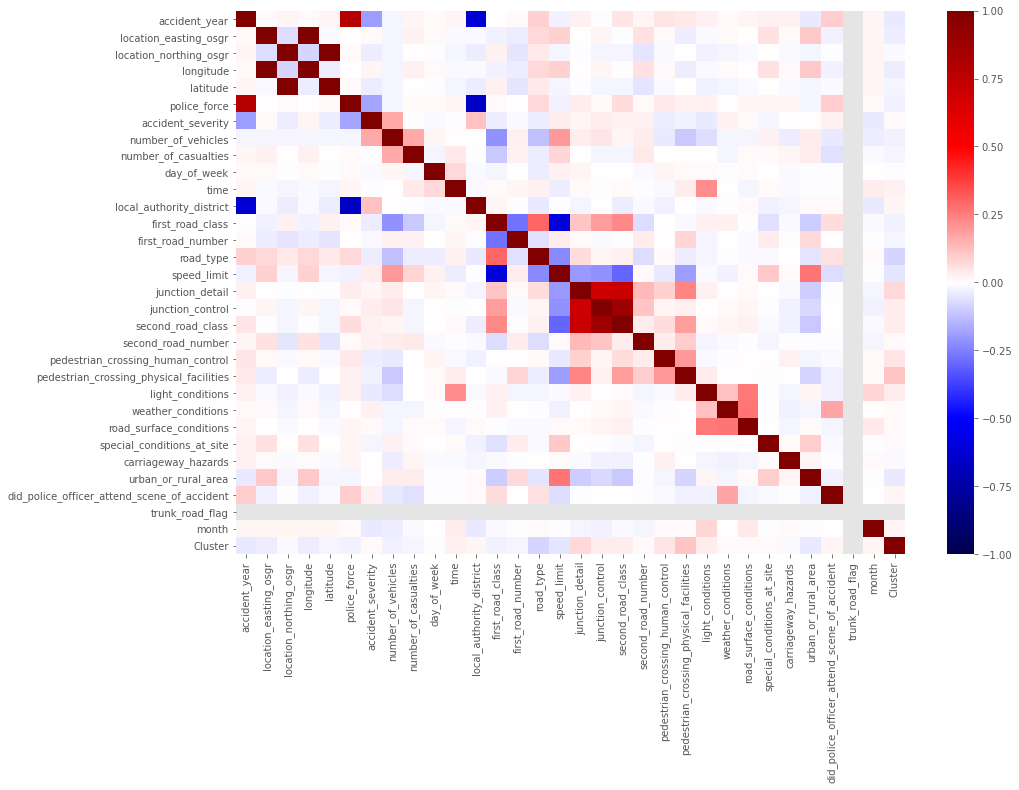

In [25]:
corr_matrix = accident.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="accident", edgecolor="#666")
plt.show()

In [26]:
accident_feature = accident[['longitude','latitude','accident_year','month','time','day_of_week','accident_severity','road_type','speed_limit','junction_detail','light_conditions','weather_conditions','road_surface_conditions']]
accident_feature.head()

longitude   latitude  accident_year  month  time  day_of_week  \
97186  -4.198684  55.867756           2021      1    12            6   
97189  -4.274333  55.814433           2021      1    21            7   
97201  -4.141377  55.861505           2021      1    16            2   
97203  -4.180351  55.844365           2021      1    12            6   
97222  -4.221841  55.862675           2021      1    18            6   

       accident_severity  road_type  speed_limit  junction_detail  \
97186                  3          6         30.0                0   
97189                  3          6         30.0                0   
97201                  2          3         40.0                0   
97203                  3          6         30.0                0   
97222                  3          6         30.0                0   

       light_conditions  weather_conditions  road_surface_conditions  
97186                 1                   1                        2  
97189                 4                   8                        4  
97201                 1                   1                        2  
97203                 1                   8                        4  
97222                 4                   8                        4

The matrix below represents the correlation of the selected features. There is a slightly significant correlation between time and light conditions, due to the fact that light conditions contain both bright and dark, depending on the time of day. And light and weather can affect road surface conditions as well. Whereas, these correlations are not significant which can be acceptable.

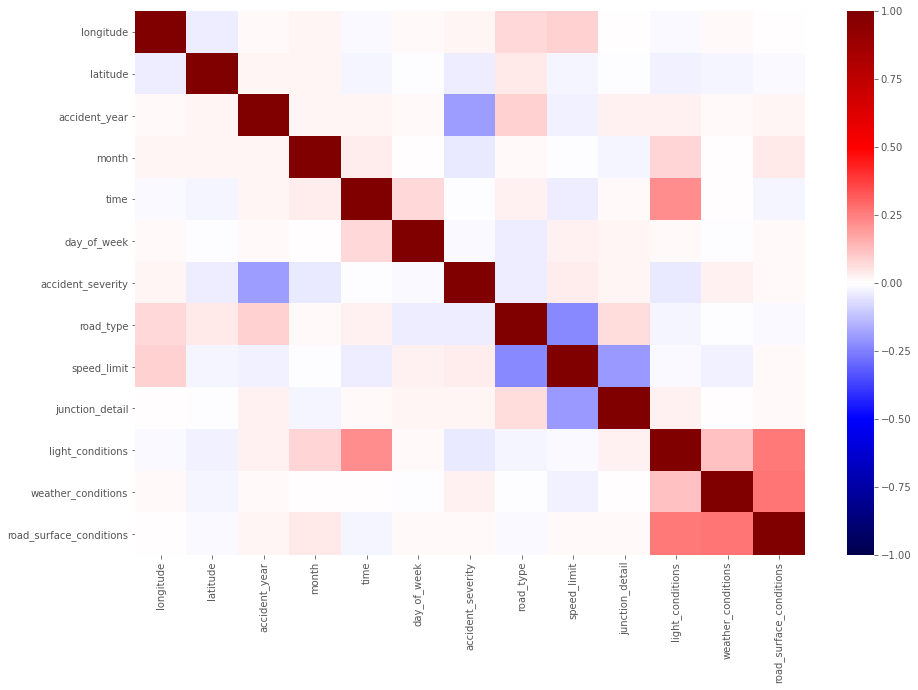

In [27]:
corr_matrix = accident_feature.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="accident_feature", edgecolor="#666")
plt.show()

In [28]:
accident_feature.describe().round(2)

longitude  latitude  accident_year    month     time  day_of_week  \
count    5218.00   5218.00        5218.00  5218.00  5218.00      5218.00   
mean       -4.26     55.86        2018.00     6.56    14.22         4.14   
std         0.06      0.02           1.65     3.52     5.05         1.92   
min        -4.39     55.79        2016.00     1.00     0.00         1.00   
25%        -4.30     55.85        2017.00     3.00    11.00         3.00   
50%        -4.26     55.86        2018.00     7.00    15.00         4.00   
75%        -4.23     55.87        2019.00    10.00    18.00         6.00   
max        -4.08     55.93        2021.00    12.00    23.00         7.00   

       accident_severity  road_type  speed_limit  junction_detail  \
count            5218.00    5218.00      5218.00          5218.00   
mean                2.79       4.82        32.60             2.96   
std                 0.43       1.72         8.77             2.92   
min                 1.00       1.00        20.00             0.00   
25%                 3.00       3.00        30.00             0.00   
50%                 3.00       6.00        30.00             3.00   
75%                 3.00       6.00        30.00             6.00   
max                 3.00       9.00        70.00             9.00   

       light_conditions  weather_conditions  road_surface_conditions  
count           5218.00             5218.00                  5218.00  
mean               1.99                1.64                     1.40  
std                1.50                1.68                     0.58  
min                1.00                1.00                     1.00  
25%                1.00                1.00                     1.00  
50%                1.00                1.00                     1.00  
75%                4.00                2.00                     2.00  
max                7.00                9.00                     5.00

## Over-sampling
The histogram of the severity of traffic accidents (shown below) shows that the data distribution is very unbalanced. Slight accidents have a much larger amount of data than the other two categories and have over 4,000 data, which is the ideal sample size data. Therefore, the data are oversampled to achieve a balance between the three data volumes.

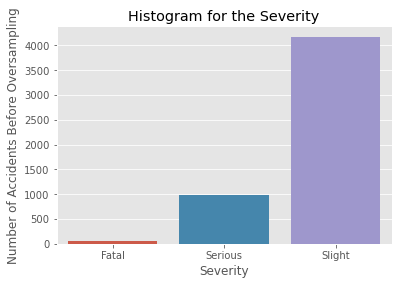

In [29]:
#unbalance data
severity_counts = accident_feature["accident_severity"].value_counts().sort_index()
labels = ['Fatal','Serious','Slight']

plt.title("Histogram for the Severity")
sns.barplot(labels, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Number of Accidents Before Oversampling")
plt.show()

In [30]:
#smote over-sampling
y = accident_feature["accident_severity"]
x = accident_feature.drop("accident_severity", axis=1)

model_smote=SMOTE()
x_resampled, y_resampled = model_smote.fit_resample(x,y)
y_resampled = pd.DataFrame(y_resampled)

accident_feature_resampled=pd.concat([x_resampled,y_resampled],axis=1)
accident_feature_resampled.head()

longitude   latitude  accident_year  month  time  day_of_week  road_type  \
0  -4.198684  55.867756           2021      1    12            6          6   
1  -4.274333  55.814433           2021      1    21            7          6   
2  -4.141377  55.861505           2021      1    16            2          3   
3  -4.180351  55.844365           2021      1    12            6          6   
4  -4.221841  55.862675           2021      1    18            6          6   

   speed_limit  junction_detail  light_conditions  weather_conditions  \
0         30.0                0                 1                   1   
1         30.0                0                 4                   8   
2         40.0                0                 1                   1   
3         30.0                0                 1                   8   
4         30.0                0                 4                   8   

   road_surface_conditions  accident_severity  
0                        2                  3  
1                        4                  3  
2                        2                  2  
3                        4                  3  
4                        4                  3

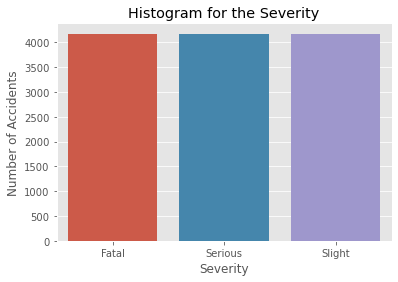

In [31]:
severity_counts = accident_feature_resampled["accident_severity"].value_counts().sort_index()
labels = ['Fatal','Serious','Slight']

plt.title("Histogram for the Severity")
sns.barplot(labels, severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Number of Accidents")
plt.show()

## 6. Prediction
Chen et al. (2020) showed that random forests showed superior capabilities in terms of accuracy, sensitivity and specificity, compared to logistic regression and decision trees. Therefore, this project uses random forests for traffic accident severity prediction based on the above-selected features.

In [32]:
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

In [33]:
# Train/Validation - Test split
X = accident_feature_resampled
X, X_test = train_test_split(X, test_size=.2, random_state=42)
print(X.shape, X_test.shape)

(10015, 13) (2504, 13)


In [34]:
sample = X
y_sample = sample["accident_severity"]
X_sample = sample.drop("accident_severity", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7511, 12) (7511,)
(2504, 12) (2504,)


In [35]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
print("Train score:", rfc.score(X_train, y_train))
print("Test score:", rfc.score(X_test, y_test))

Train score: 1.0
Test score: 0.8578274760383386


In [36]:
y_pred = rfc.predict(X_test)

accuracy["Decision Tree"] = accuracy_score(y_test, y_pred)
f1["Decision Tree"] = f1_score(y_test, y_pred, average="macro")

print(classification_report(y_train, rfc.predict(X_train)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2479
           2       1.00      1.00      1.00      2523
           3       1.00      1.00      1.00      2509

    accuracy                           1.00      7511
   macro avg       1.00      1.00      1.00      7511
weighted avg       1.00      1.00      1.00      7511

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       867
           2       0.79      0.79      0.79       828
           3       0.79      0.78      0.79       809

    accuracy                           0.86      2504
   macro avg       0.85      0.86      0.85      2504
weighted avg       0.86      0.86      0.86      2504



The F1-scores for both the training and test sets of the model are equal to or close to 1, indicating that the model achieves a good balance between accuracy and recall. The model has good performance in terms of fitting ability and generalisation ability.

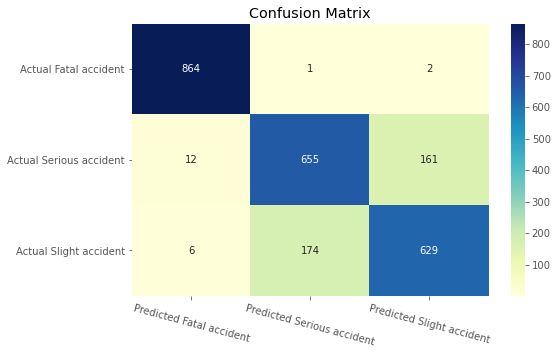

In [37]:
y_pred = rfc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

index = ["Actual Fatal accident", "Actual Serious accident", "Actual Slight accident"]
columns = ["Predicted Fatal accident", "Predicted Serious accident", "Predicted Slight accident"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xticks(rotation = -15)
plt.show()

The confusion matrix above shows that the highest number of fatal accidents is predicted correctly. In contrast, the amount of data predicted correctly for serious and slight accidents are similar, and most of the data predicted incorrectly is confounded between these two types of accidents, indicating that the distinction between the characteristics of slight and serious accidents needs to be improved.

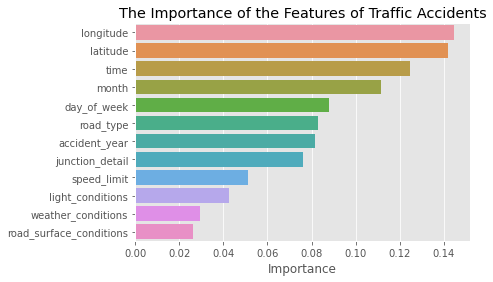

In [38]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["Importance"], index=X_train.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="Importance", ascending=False)

sns.barplot(x="Importance", y=importances.index, data=importances)
plt.title('The Importance of the Features of Traffic Accidents')

plt.show()

As can be seen from the above graph of the importance of the features of traffic accidents, for predicting the severity of a traffic accident, the latitude and longitude of the accident are the most important, i.e., the geographical location, whose importance is nearly 7 times more than the importance of road surface conditions which is the least important. And the next most important are the time of day and the month, while light conditions and weather conditions are less important.

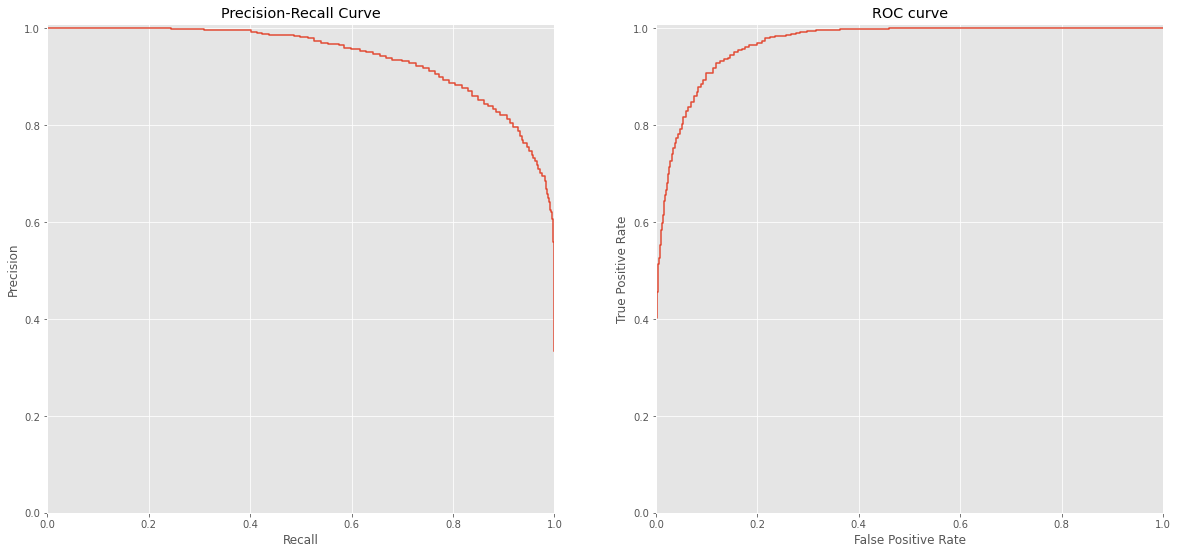

In [39]:
Y = label_binarize(y_test, classes=[1, 2, 3])

y_score = rfc.predict_proba(X_test)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(20, 9))

plt.subplot(1, 2, 1)
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("Precision-Recall Curve")

plt.subplot(1, 2, 2)
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])

plt.show()

Both the PR and ROC curves of this model demonstrate good performance, meaning that both the accuracy of predicting serious accidents and the overall accuracy are better, which makes it a useful model for traffic safety managers and traffic engineers.

## Conclusion
Traffic accidents are a common social phenomenon and have a huge impact on the safety and development of society and individuals. The analysis of traffic accident data and the prediction of the severity of traffic accidents can help people understand the pattern and distribution of traffic accidents so that they can take action to reduce the probability and severity of traffic accidents.

And traffic accidents are influenced by many factors and exhibit different characteristics at different times and geographical locations. By analysing the occurrence conditions and location characteristics of traffic accidents in Glasgow from 2016 to 2021, as well as building a prediction model of the severity of traffic accidents using random forests, this project yields the following key findings:

1. The number of traffic accidents is decreasing year on year, mainly in the form of a significant decrease in slight accidents.
2. January, October, and November, Saturdays, and the morning and evening peaks are the time periods when more traffic accidents occur, and the evening peak is more prone to traffic accidents than the morning peak.
3. Slight accidents accounted for the highest number of accidents at 80%, while serious and fatal accidents accounted for 19% and 1% respectively.
4. The highest number of accidents occurred in common conditions (good weather without high winds, daylight, dry roads).
5. Junctions and single carriageways are frequent sites of traffic accidents.
6. Glasgow's city centre and the motorways around the city centre are prone to traffic accidents.
7. Serious and fatal traffic accidents are geographically dispersed.
8. Fatal accidents are most accurately predicted and the distinction between slight and serious traffic accident characteristics is not particularly clear.
9. Geographical location is the most important feature in predicting traffic accident severity, followed by the time of occurrence.

Common conditions are the ones where the most accidents occur, rather than severe or extreme conditions such as windy weather, and icy or snowy roads. This may be because such adverse or extreme conditions do not occur for as long as they should, but also because the number of people travelling in such conditions has also decreased. Furthermore, the fact that the roads with a speed limit of 30 have the most accidents does not indicate that other roads with speed limits are less prone to accidents. Roads with speed limits of 20 and 50 have a higher number of accidents than roads with other speed limits, suggesting that accidents can occur at both too fast and too slow speeds.

Based on the results of the above analysis, this project makes a number of suggestions for travelling citizens, road safety managers and road safety policymakers. To be specified, travellers can try to avoid places and times of day that are prone to traffic accidents, but if they must travel, they should do so with caution, especially in good weather and fine travel conditions. Secondly, traffic safety managers can deploy rescue resources and develop more effective traffic safety management measures and plans by predicting the severity of traffic accidents. In addition, road safety policymakers could strengthen controls on pedestrian and vehicle flows during peak periods, with a focus on accident-prone roads such as junctions and the M8 motorway, and improve policies in a timely manner.

To sum up, this report provides an in-depth discussion and analysis of the pattern and severity of traffic accidents from different perspectives. And then based on the results of the analysis, make suggestions for the formulation of more scientific and evidence-based road safety-related policies and management measures to reduce the occurrence of traffic accidents and the negative impact of traffic accidents on society and individuals.


**Word Count**: 2744

## Reference
ABELLAN, J., LOPEZ, G. & DE ONA, J. 2013, "Analysis of traffic accident severity using Decision Rules via Decision Trees", Expert systems with applications, vol. 40, no. 15, pp. 6047-6054. doi: https://doi.org/10.1016/j.eswa.2013.05.027

Chen, M. & Chen, M. 2020, "Modeling Road Accident Severity with Comparisons of Logistic Regression, Decision Tree and Random Forest", Information (Basel), vol. 11, no. 5, pp. 270. doi: https://doi.org/10.3390/info11050270

Department for Transport (2021) Road traffic estimates in Great Britain: 2021. Available at:
https://www.gov.uk/government/statistics/road-traffic-estimates-in-great-britain-2021 (Accessed at: 26 March 2023)

Mou, Z., Jin, C., Wang, H., Chen, Y., Li, M. & Chen, Y. (2022) "Spatial influence of engineering construction on traffic accidents, a case study of Jinan", Accident analysis and prevention, vol. 177, pp. 106825-106825. doi: https://doi.org/10.1016/j.aap.2022.106825 
NHTSA (2023) 

NHTSA: Traffic Crashes Cost America $340 Billion in 2019. Available at:  https://www.nhtsa.gov/press-releases/traffic-crashes-cost-america-billions-2019 (Accessed at: 26 March 2023).

Statista (2021) Average cost of road casualties and accidents by severity in Great Britain in 2020. Available at: https://www.statista.com/statistics/322862/average-cost-of-road-accidents-and-casualties-in-great-britain-uk/ (Accessed at: 26 March 2023)

Transport Scotland (2014) Reported Road Casualties Scotland 2014. Available at:
https://www.transport.gov.scot/publication/reported-road-casualties-scotland-2014-7/appendix-d-definitions-used-in-road-accident-statistics-and-some-other-points-to-note/  (Accessed at: 26 March 2023)

Zhang, X., Liu, L., Xiao, L. & Ji, J. (2020) "Comparison of Machine Learning Algorithms for Predicting Crime Hotspots", IEEE access, vol. 8, pp. 181302-181310. doi: https://doi.org/10.1109/ACCESS.2020.3028420
